# Annotate cell identity of scRNAseq data
**Author**: Adam Klie (last modified: 10/12/2023)<br>
***
**Description**: This script 

In [2]:
# Imports
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import os
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
import decoupler as dc
from celltypist import models
#import scarches as sca
import urllib.request

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [231]:
# Paths
input_h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/12Oct23/A2_control/dm45a/dimensionality_reduction/6_dimensionality-reduction_scRNAseq.h5ad"
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/12Oct23/A2_control/dm45a/annotation"

In [232]:
# Read in h5ad
adata = sc.read_h5ad(input_h5ad_path)
adata

AnnData object with n_obs × n_vars = 5155 × 16209
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'at

In [233]:
# Make output directory if it doesn't exist
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

# Manual annotation

In [260]:
# Define global run parameters
output_prefix = "annotate"
marker_genes = {
    "SC.beta": ["INS", "IAPP", "PDX1"],
    "SC.alpha": ["GCG", "ARX"],
    "SC.delta": ["SST", "HHEX"],
    "SC.EC": ["TPH1", "SLC18A1"],
    "endocrine_progenitor": ["ZEB2", "NEUROG3", "FEV"],
    "pancreatic_progenitor": ["SOX9", "ONECUT1", "KRT19"],
    "proliferating_alpha": ["MKI67"],
}
pca_n_comps = 50
n_neighbors = 30
random_state = 13

In [262]:
# Create a dataframe with two columns: gene and cell_id from the marker genes dictionary
marker_genes_df = pd.DataFrame(
    [(gene, cell_id) for cell_id, genes in marker_genes.items() for gene in genes],
    columns=["gene", "cell_id"],
)

In [264]:
marker_genes_df.to_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/18Oct23/SC.islet.marker_genes.csv", index=False)

In [269]:
marker_genes_df = pd.read_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/18Oct23/SC.islet.marker_genes.csv")

In [270]:
marker_genes_df

gene                cell_id
0       INS                SC.beta
1      IAPP                SC.beta
2      PDX1                SC.beta
3       GCG               SC.alpha
4       ARX               SC.alpha
5       SST               SC.delta
6      HHEX               SC.delta
7      TPH1                  SC.EC
8   SLC18A1                  SC.EC
9      ZEB2   endocrine_progenitor
10  NEUROG3   endocrine_progenitor
11      FEV   endocrine_progenitor
12     SOX9  pancreatic_progenitor
13  ONECUT1  pancreatic_progenitor
14    KRT19  pancreatic_progenitor
15    MKI67    proliferating_alpha

In [271]:
# Now do the reverse: create a dictionary with cell_id as key and genes as a list of values
marker_genes_dict = marker_genes_df.groupby("cell_id")["gene"].apply(list).to_dict()
marker_genes_dict

{'SC.EC': ['TPH1', 'SLC18A1'],
 'SC.alpha': ['GCG', 'ARX'],
 'SC.beta': ['INS', 'IAPP', 'PDX1'],
 'SC.delta': ['SST', 'HHEX'],
 'endocrine_progenitor': ['ZEB2', 'NEUROG3', 'FEV'],
 'pancreatic_progenitor': ['SOX9', 'ONECUT1', 'KRT19'],
 'proliferating_alpha': ['MKI67']}

In [235]:
# Check markers against adata.var
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

# Remove any keys with lists of length 0
marker_genes_in_data = {k: v for k, v in marker_genes_in_data.items() if len(v) > 0}
marker_genes_in_data

{'SC.beta': ['INS', 'IAPP', 'PDX1'],
 'SC.alpha': ['GCG', 'ARX'],
 'SC.delta': ['SST'],
 'SC.EC': ['TPH1', 'SLC18A1'],
 'endocrine_progenitor': ['ZEB2', 'FEV']}

In [236]:
# Grab the layer to do the plotting with
adata.X = adata.layers["log1p_norm"]

In [237]:
# Grab the reduction to plot on
adata.obsm["X_pca"] = adata.obsm["sctransform_seurat_pca"]
adata.obsm["X_umap"] = adata.obsm["sctransform_seurat_umap"]

In [238]:
# Make sure you have the correc
#adata.var["highly_variable"] = adata.var["log1p_norm_highly_variable"]

In [239]:
# Not sure why I need to do this again
sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=pca_n_comps)

In [240]:
# Higher resolution clustering
sc.tl.leiden(adata, resolution=1, key_added="leiden_1")

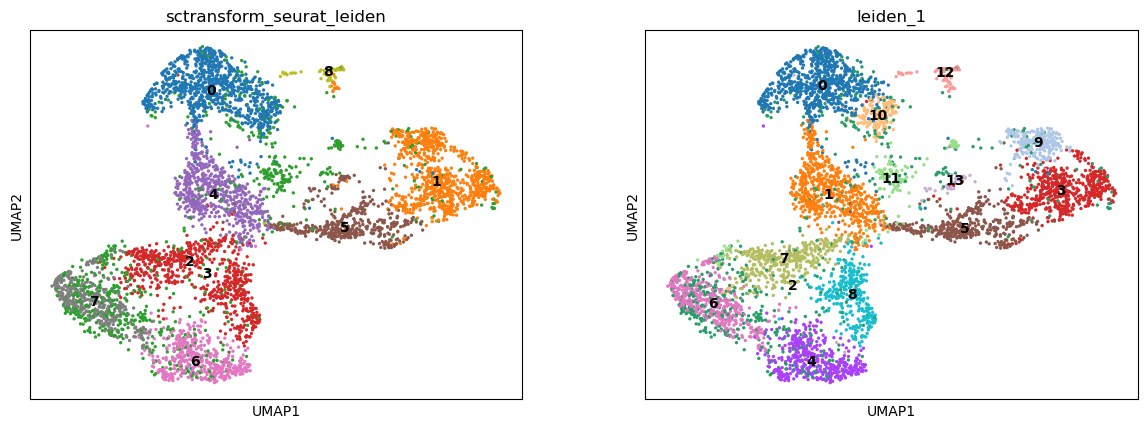

In [241]:
## Unsupservised clustering
sc.pl.umap(adata, color=["sctransform_seurat_leiden", "leiden_1"], legend_loc="on data")

SC.BETA:


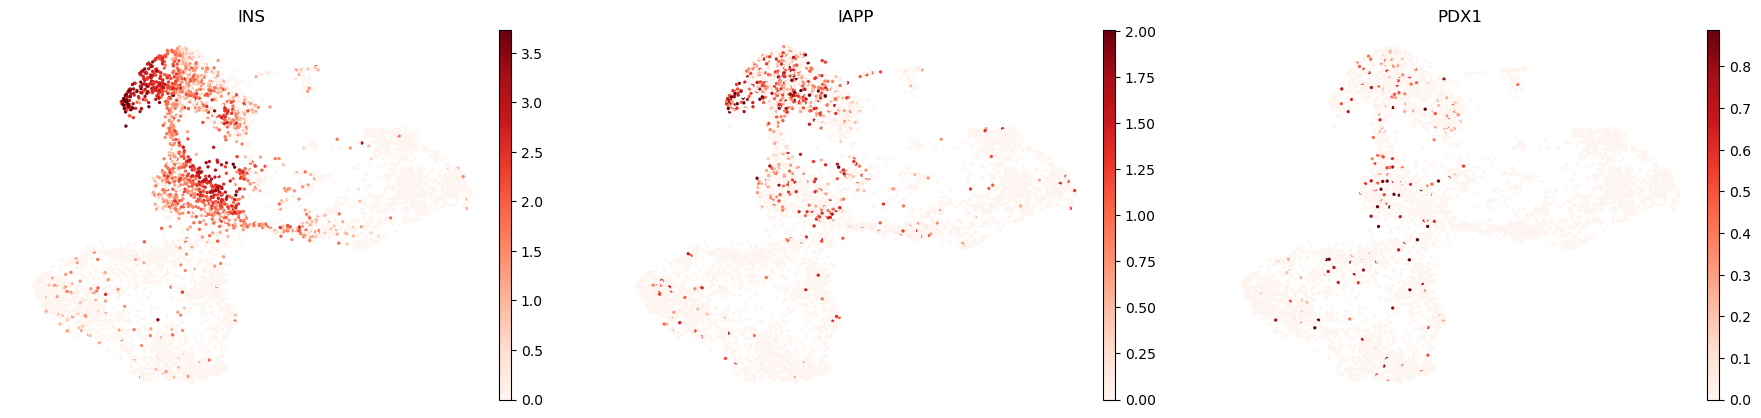





SC.ALPHA:


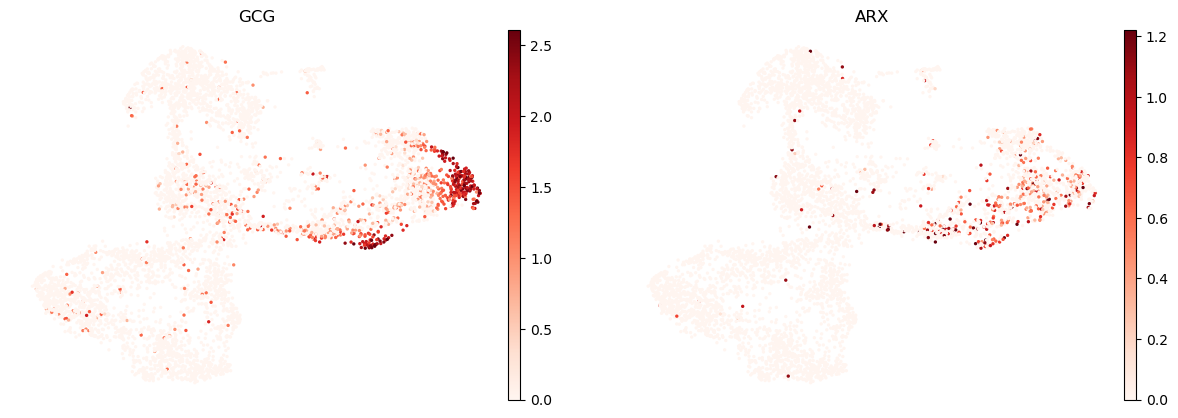





SC.DELTA:


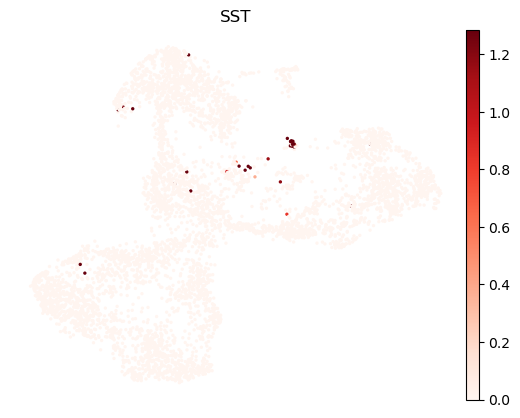





SC.EC:


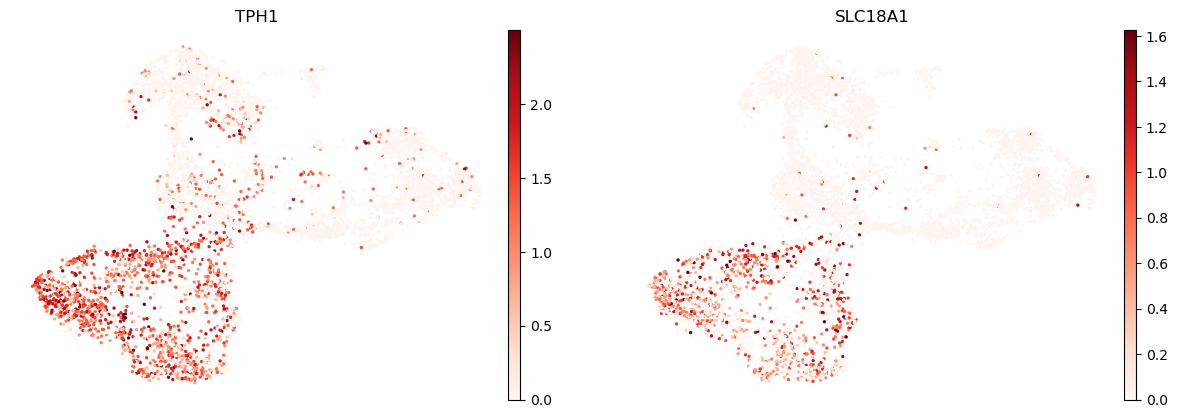





ENDOCRINE_PROGENITOR:


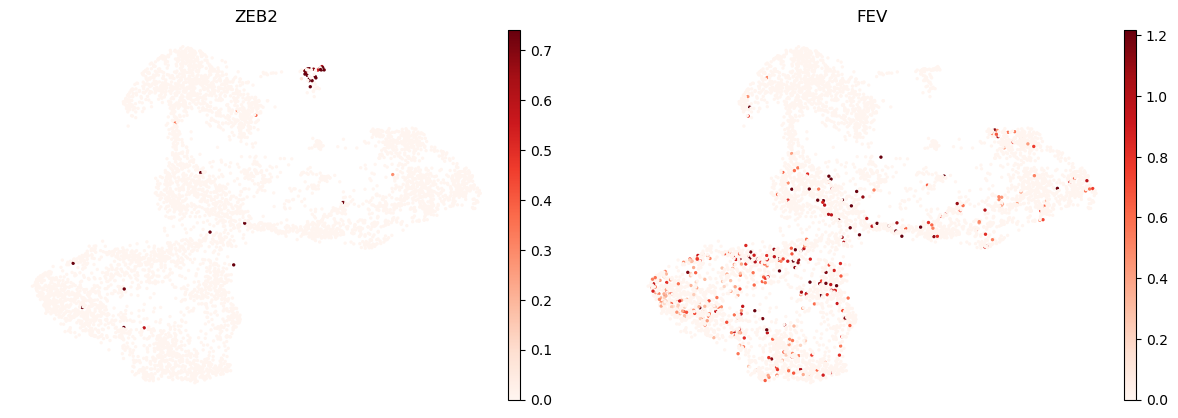

In [242]:
for ct in marker_genes_in_data.keys():
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        adata,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99.5",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility

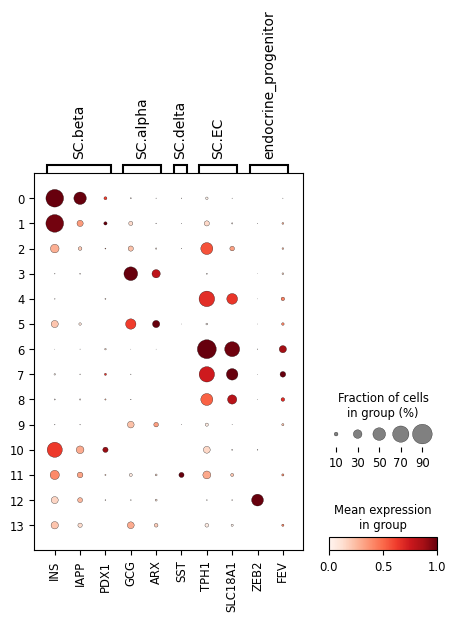

In [243]:
sc.pl.dotplot(
    adata,
    groupby="leiden_1",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [244]:
# Find marker genes for clusters
sc.tl.rank_genes_groups(
    adata, groupby="leiden_1", method="wilcoxon", key_added="dea_leiden_1"
)

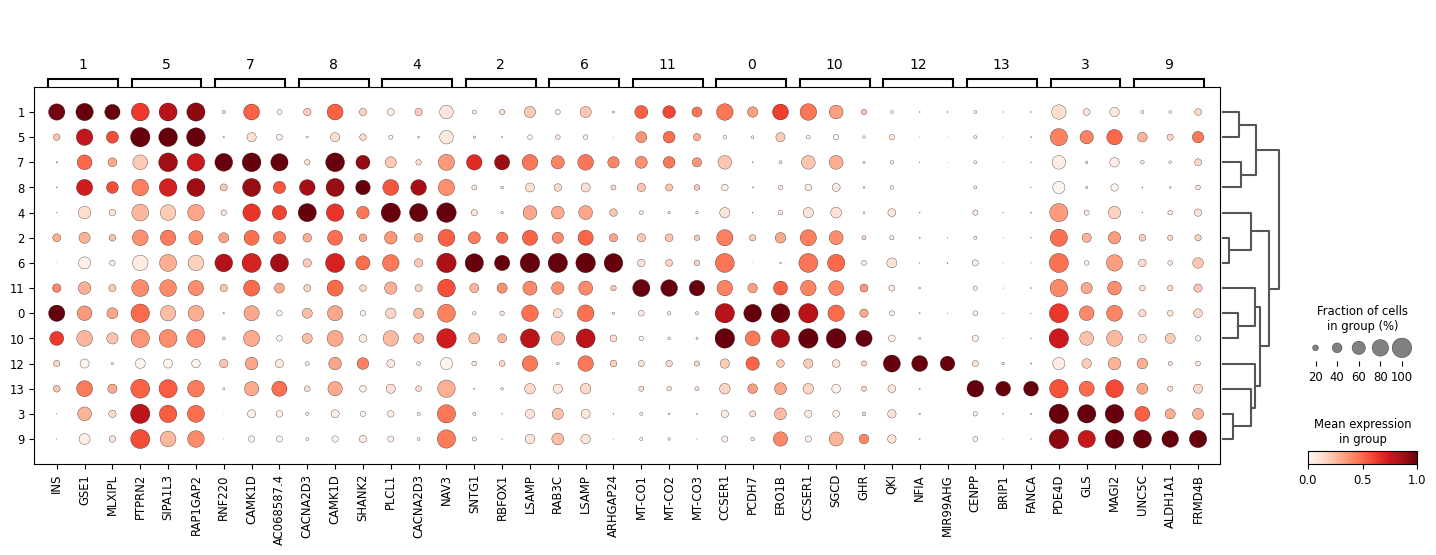

In [245]:
# Dot plot those markers
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_1", standard_scale="var", n_genes=3, key="dea_leiden_1"
)

In [246]:
# Filter these results to genes that are highly specific to each cluster
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden_1",
    key_added="dea_leiden_1_filtered",
)

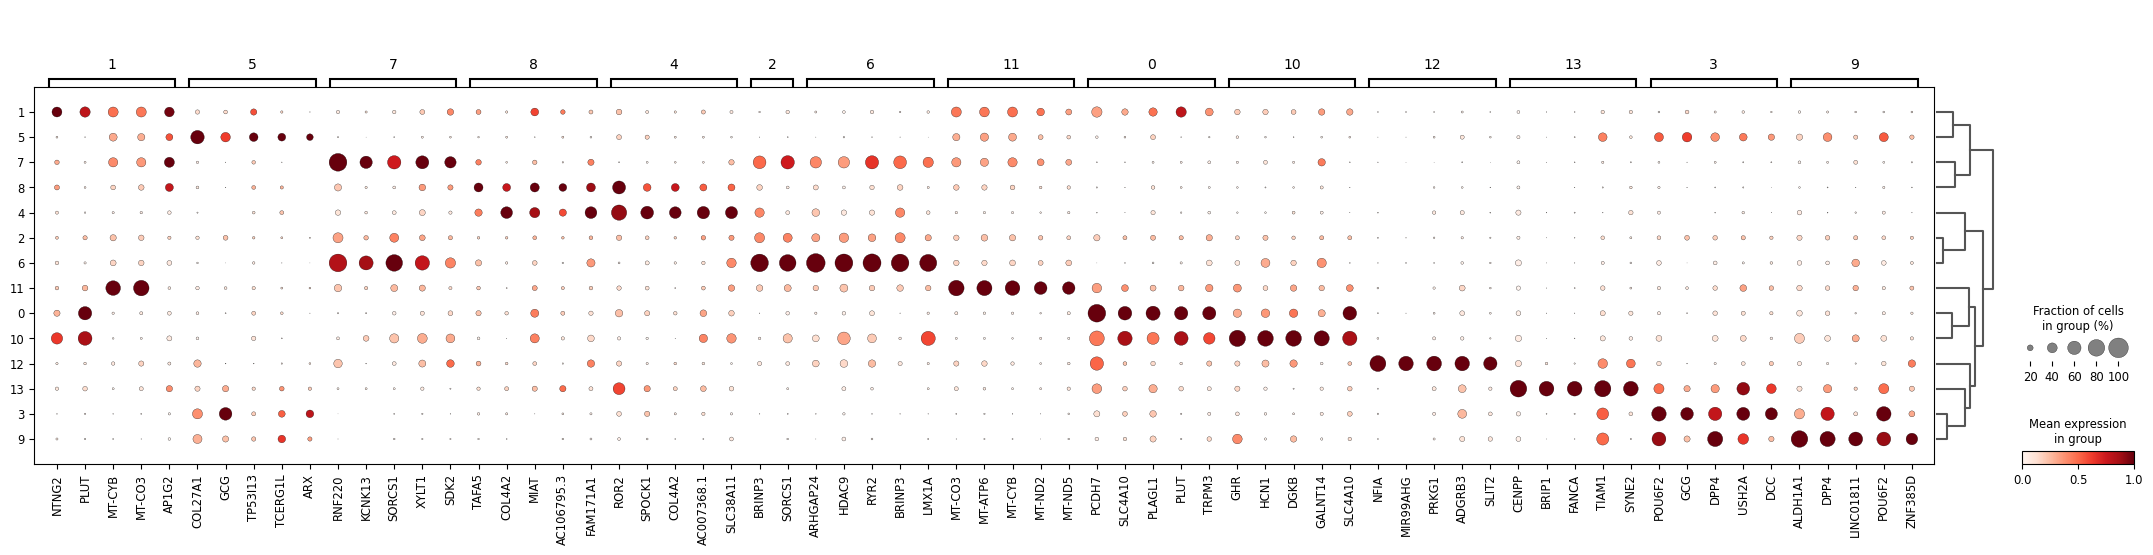

In [247]:
# Dot plot those markers
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden_1",
    standard_scale="var",
    n_genes=5,
    key="dea_leiden_1_filtered",
)

In [209]:
# Prompt the user to create a dictionary that maps each cluster number to a provided cell type
cluster_to_celltype = dict()
numerically_sorted_clusters = sorted(adata.obs["leiden_1"].unique(), key=lambda x: int(x))
numerically_sorted_clusters

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

In [210]:
# Get input from user, make the options to choose from only the keys to the marker_genes_in_data dictionary
for cluster in numerically_sorted_clusters:
    print(f"Cluster {cluster}:")
    cluster_to_celltype[cluster] = input("Enter cell type: ")
    print("\n")

Cluster 0:


Cluster 1:


Cluster 2:


Cluster 3:


Cluster 4:


Cluster 5:


Cluster 6:


Cluster 7:


Cluster 8:


Cluster 9:


Cluster 10:


Cluster 11:


Cluster 12:


Cluster 13:




In [248]:
# Add the annotation to obs
adata.obs["manual_celltype_annotation"] = adata.obs.leiden_1.map(cluster_to_celltype)

... storing 'manual_celltype_annotation' as categorical


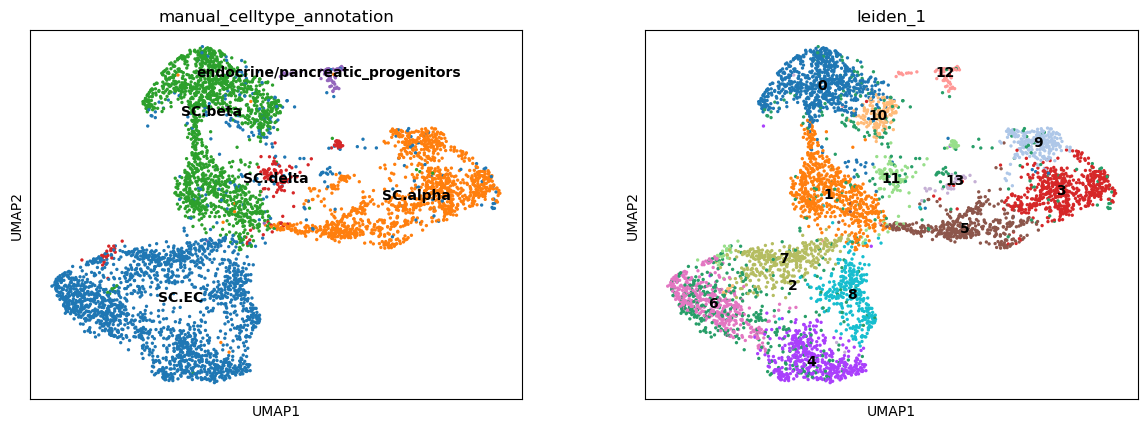

In [249]:
# Plot along with clusters
sc.pl.umap(adata, color=["manual_celltype_annotation", "leiden_1"], legend_loc="on data")

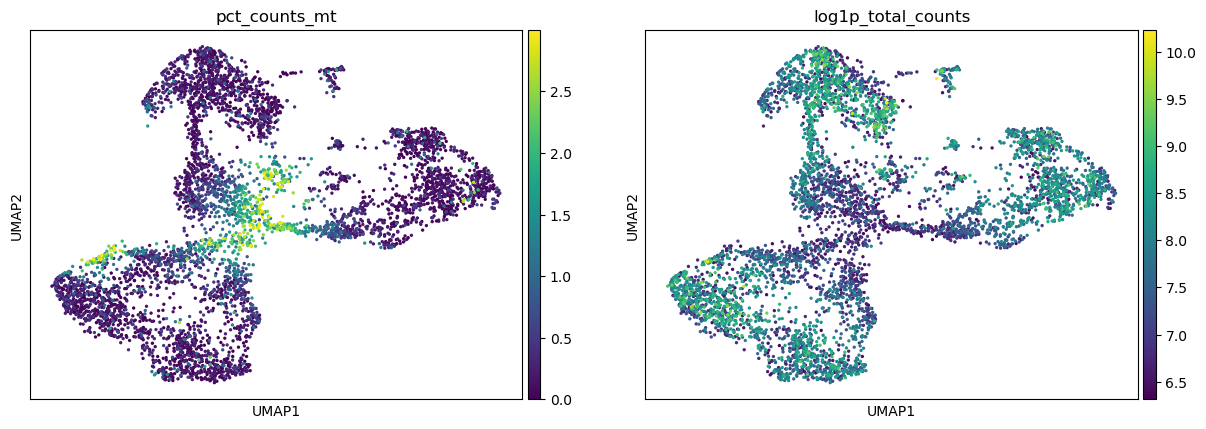

In [250]:
# Plot along with clusters
sc.pl.umap(adata, color=["pct_counts_mt", "log1p_total_counts"], legend_loc="on data")

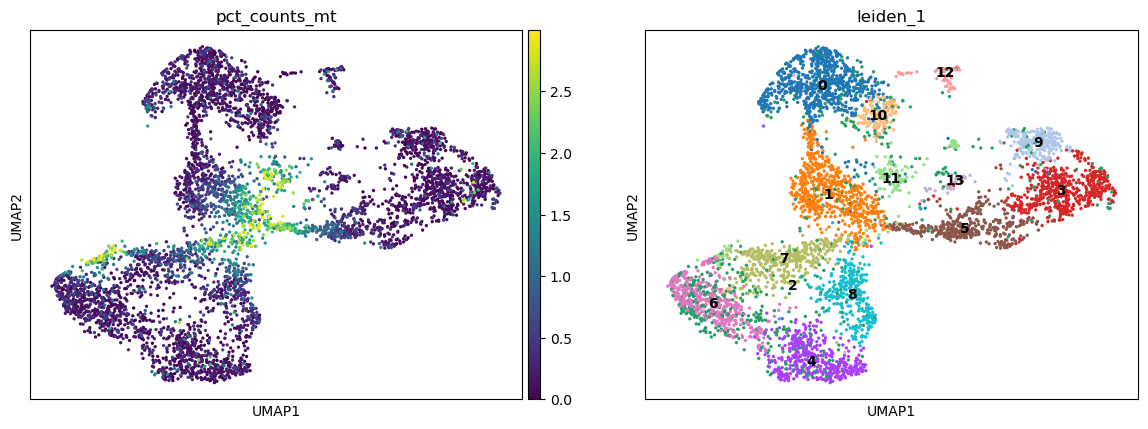

In [251]:
# Plot along with clusters
sc.pl.umap(adata, color=["pct_counts_mt", "leiden_1"], legend_loc="on data")

In [252]:
sc.tl.rank_genes_groups(
    adata, groupby="manual_celltype_annotation", method="wilcoxon", key_added="dea_manual_celltype_annotation"
)

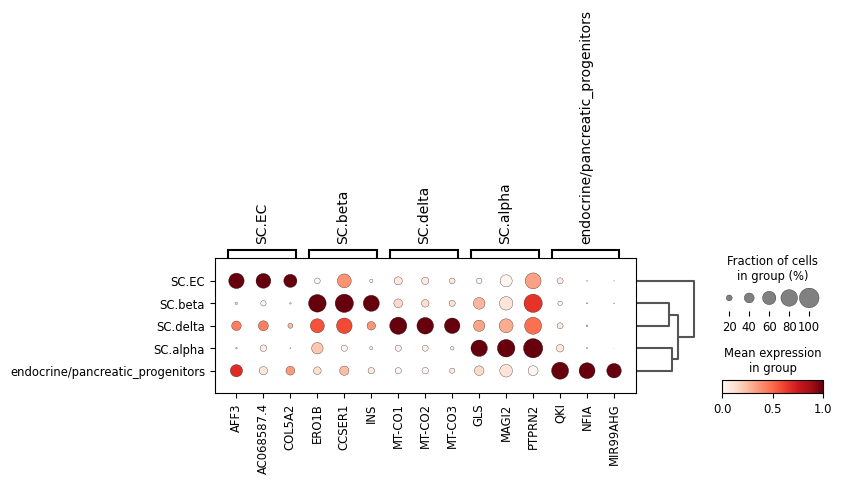

In [253]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="manual_celltype_annotation", standard_scale="var", n_genes=3, key="dea_manual_celltype_annotation"
)

In [254]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_manual_celltype_annotation",
    key_added="dea_manual_celltype_annotation_filtered",
)

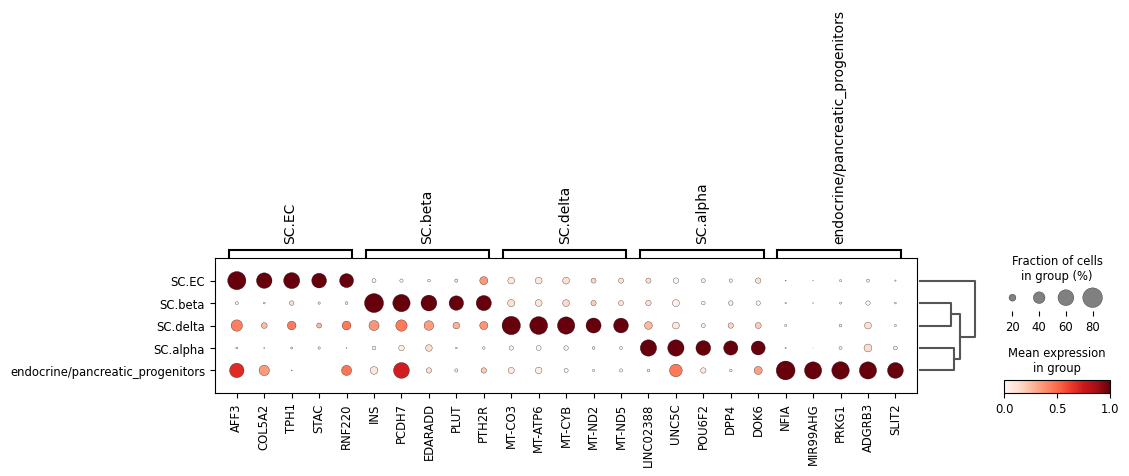

In [255]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="manual_celltype_annotation",
    standard_scale="var",
    n_genes=5,
    key="dea_manual_celltype_annotation_filtered",
)

In [256]:
metadata_cols = [
    'total_counts', 'pct_counts_mt', 'leiden_1', 'manual_celltype_annotation'
]
adata.obs[metadata_cols].to_csv(os.path.join(outdir_path, f"annotation_metadata.csv"))

In [257]:
del adata.uns["dea_manual_celltype_annotation_filtered"]

In [258]:
del adata.uns["dea_leiden_1_filtered"]

In [259]:
# Save the filtered data.
adata.write(os.path.join(outdir_path, f"{output_prefix}.h5ad"))

## Bonus: Check against Han's annotation

In [178]:
pd.read_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/18Oct23/mo38/h1.anno.csv", index_col=0)

x
1        SC.EC
2      SC.beta
3        SC.EC
4        SC.EC
5     SC.alpha
...        ...
5540  SC.alpha
5541     SC.EC
5542   SC.beta
5543     SC.EC
5544  SC.alpha

[5544 rows x 1 columns]

# CellTypist

In [69]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [71]:
models.download_models(
    force_update=True, model=["Adult_Human_PancreaticIslet.pkl", "Fetal_Human_Pancreas.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in /cellar/users/aklie/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [2/2]: Fetal_Human_Pancreas.pkl


🔬 Input data has 2834 cells and 16627 genes
🔗 Matching reference genes in the model
🧬 1643 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


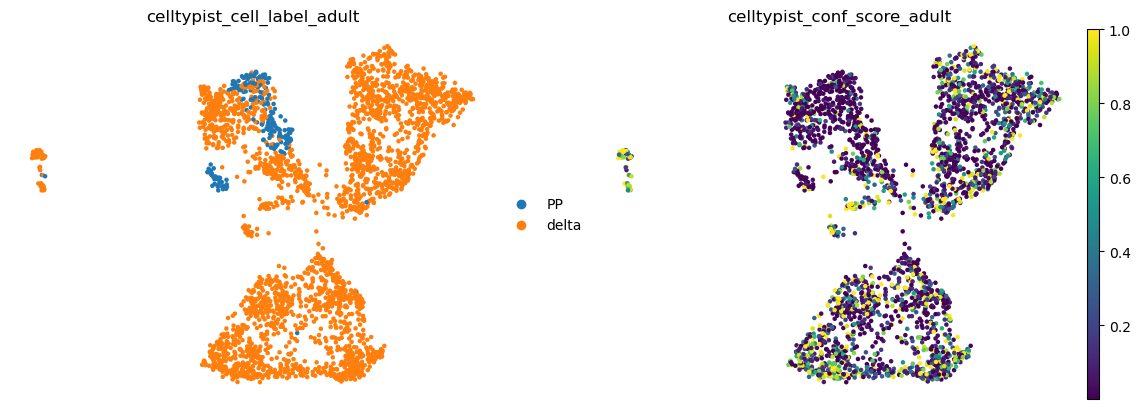

In [73]:
model_adult = models.Model.load(model="Adult_Human_PancreaticIslet.pkl")

predictions_adult = celltypist.annotate(
    adata_celltypist, model=model_adult, majority_voting=True
)

predictions_adult_adata = predictions_adult.to_adata()

adata.obs["celltypist_cell_label_adult"] = predictions_adult_adata.obs.loc[adata.obs.index, "majority_voting"]
adata.obs["celltypist_conf_score_adult"] = predictions_adult_adata.obs.loc[adata.obs.index, "conf_score"]

sc.pl.umap(
    adata,
    color=["celltypist_cell_label_adult", "celltypist_conf_score_adult"],#, "manual_celltype_annotation"],
    frameon=False,
    sort_order=False,
    wspace=0.1,
)

🔬 Input data has 2834 cells and 16627 genes
🔗 Matching reference genes in the model
🧬 3166 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


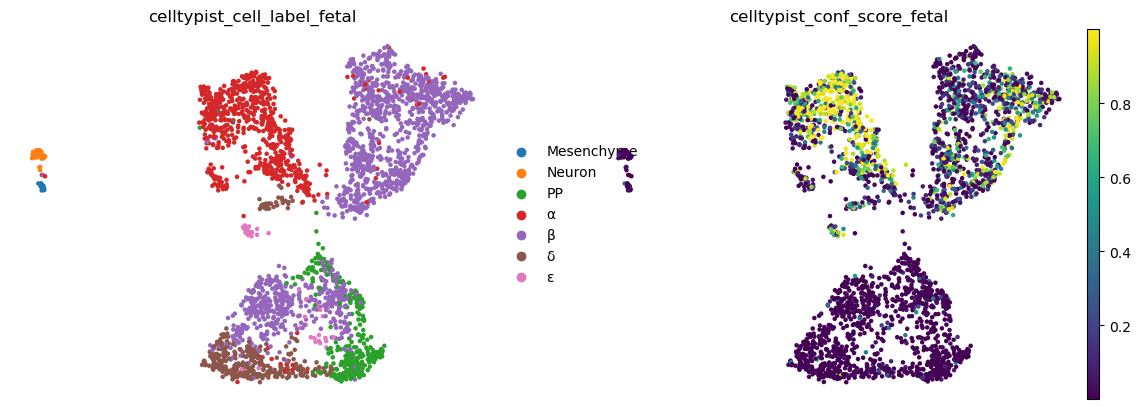

In [74]:
model_fetal = models.Model.load(model="Fetal_Human_Pancreas.pkl")

predictions_fetal = celltypist.annotate(
    adata_celltypist, model=model_fetal, majority_voting=True
)


predictions_fetal_adata = predictions_fetal.to_adata()

adata.obs["celltypist_cell_label_fetal"] = predictions_fetal_adata.obs.loc[adata.obs.index, "majority_voting"]
adata.obs["celltypist_conf_score_fetal"] = predictions_fetal_adata.obs.loc[adata.obs.index, "conf_score"]

sc.pl.umap(
    adata,
    color=["celltypist_cell_label_fetal", "celltypist_conf_score_fetal"],#, "manual_celltype_annotation"],
    frameon=False,
    sort_order=False,
    wspace=0.1
)

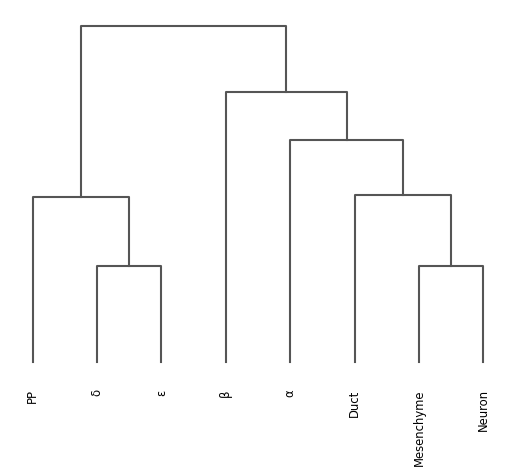

<Axes: >

In [33]:
sc.pl.dendrogram(adata, groupby="celltypist_cell_label_fetal")

In [34]:
pd.crosstab(adata.obs.celltypist_cell_label_fetal, adata.obs.manual_celltype_annotation)

manual_celltype_annotation   SC.EC  SC.alpha  SC.beta  SC.delta  SC.pre.alpha  \
celltypist_cell_label_fetal                                                     
Duct                             9         0        1         0             0   
Mesenchyme                       0         0        0         0             0   
Neuron                           0         0        0         0             0   
PP                             314         0        1         0             0   
α                                3       460       24         1           195   
β                               70         1     1235         0             0   
δ                              613         0        2        35             9   
ε                              109         0        1        29             0   

manual_celltype_annotation   progenitor  
celltypist_cell_label_fetal              
Duct                                  0  
Mesenchyme                           23  
Neuron                               42  
PP                                    0  
α                                     1  
β                                     0  
δ                                     0  
ε                                     0

# Decoupler-py

In [77]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

genesymbol canonical_marker          cell_type germ_layer human  \
0         CTRB1            False        Enterocytes   Endoderm  True   
1         CTRB1             True       Acinar cells   Endoderm  True   
2          KLK1             True  Endothelial cells   Mesoderm  True   
3          KLK1            False       Goblet cells   Endoderm  True   
4          KLK1            False   Epithelial cells   Mesoderm  True   
...         ...              ...                ...        ...   ...   
8456    SLC14A1             True   Urothelial cells   Mesoderm  True   
8457      UPK3A             True   Urothelial cells   Mesoderm  True   
8458      UPK1A             True   Urothelial cells   Mesoderm  True   
8459       UPK2             True   Urothelial cells   Mesoderm  True   
8460      UPK3B             True   Urothelial cells   Mesoderm  True   

     human_sensitivity human_specificity mouse mouse_sensitivity  \
0                  0.0        0.00439422  True        0.00331126   
1                  1.0       0.000628931  True          0.957143   
2                  0.0        0.00841969  True               0.0   
3             0.588235        0.00503937  True          0.903226   
4                  0.0        0.00823306  True          0.225806   
...                ...               ...   ...               ...   
8456               0.0         0.0181704  True               0.0   
8457               0.0               0.0  True               0.0   
8458               0.0               0.0  True               0.0   
8459               0.0               0.0  True               0.0   
8460               0.0               0.0  True               0.0   

     mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0            0.0204803        9606         GI tract           0.017  
1            0.0159201        9606         Pancreas           0.017  
2            0.0149153        9606      Vasculature           0.013  
3            0.0124084        9606         GI tract           0.013  
4            0.0137585        9606       Epithelium           0.013  
...                ...         ...              ...             ...  
8456               0.0        9606  Urinary bladder           0.008  
8457               0.0        9606  Urinary bladder             0.0  
8458               0.0        9606  Urinary bladder             0.0  
8459               0.0        9606  Urinary bladder             0.0  
8460               0.0        9606  Urinary bladder             0.0  

[8461 rows x 13 columns]

In [78]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True') & (markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

genesymbol canonical_marker                     cell_type germ_layer  \
1         CTRB1             True                  Acinar cells   Endoderm   
2          KLK1             True             Endothelial cells   Mesoderm   
5          KLK1             True               Principal cells   Mesoderm   
6          KLK1             True                  Acinar cells   Endoderm   
7          KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
...         ...              ...                           ...        ...   
8456    SLC14A1             True              Urothelial cells   Mesoderm   
8457      UPK3A             True              Urothelial cells   Mesoderm   
8458      UPK1A             True              Urothelial cells   Mesoderm   
8459       UPK2             True              Urothelial cells   Mesoderm   
8460      UPK3B             True              Urothelial cells   Mesoderm   

     human human_sensitivity human_specificity mouse mouse_sensitivity  \
1     True               1.0       0.000628931  True          0.957143   
2     True               0.0        0.00841969  True               0.0   
5     True               0.0        0.00814536  True          0.285714   
6     True          0.833333        0.00503145  True          0.314286   
7     True               0.0        0.00820189  True               1.0   
...    ...               ...               ...   ...               ...   
8456  True               0.0         0.0181704  True               0.0   
8457  True               0.0               0.0  True               0.0   
8458  True               0.0               0.0  True               0.0   
8459  True               0.0               0.0  True               0.0   
8460  True               0.0               0.0  True               0.0   

     mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1            0.0159201        9606         Pancreas           0.017  
2            0.0149153        9606      Vasculature           0.013  
5            0.0140583        9606           Kidney           0.013  
6            0.0128263        9606         Pancreas           0.013  
7            0.0129136        9606    Immune system           0.013  
...                ...         ...              ...             ...  
8456               0.0        9606  Urinary bladder           0.008  
8457               0.0        9606  Urinary bladder             0.0  
8458               0.0        9606  Urinary bladder             0.0  
8459               0.0        9606  Urinary bladder             0.0  
8460               0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [79]:
adata_decoupler = adata.copy()  # make a copy of our adata
adata_decoupler.X = adata.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_decoupler, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_decoupler)  # log-transform
# make .X dense instead of sparse, for compatibility with decoupler:
adata_decoupler.X = adata_decoupler.X.toarray()
adata_decoupler.raw = adata

In [80]:
# Run ORA on top 5% of genes in each cell
dc.run_ora(
    mat=adata_decoupler,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    use_raw=True,
    verbose=True
)

Running ora on mat with 2834 samples and 16627 targets for 128 sources.


100%|██████████| 2834/2834 [00:06<00:00, 443.04it/s]


In [81]:
# Check the results
adata_decoupler.obsm['ora_estimate'].head()

source              Acinar cells  Adipocyte progenitor cells  Adipocytes  \
AAACAGCCAGGACACA-1     -0.000000                   -0.000000    0.961409   
AAACAGCCATAATCCG-1     -0.000000                   -0.000000    0.258385   
AAACATGCATCACTTC-1     -0.000000                    0.921956    0.558389   
AAACCAACAGCCTTGG-1     -0.000000                   -0.000000    0.961409   
AAACCAACATGTTTGG-1      0.589544                   -0.000000    0.258385   

source              Adrenergic neurons  Airway goblet cells  Alpha cells  \
AAACAGCCAGGACACA-1            0.647697                 -0.0     1.250857   
AAACAGCCATAATCCG-1            0.647697                 -0.0     1.250857   
AAACATGCATCACTTC-1            0.647697                 -0.0     0.111104   
AAACCAACAGCCTTGG-1            0.647697                 -0.0     2.531676   
AAACCAACATGTTTGG-1           -0.000000                 -0.0     0.111104   

source              Anterior pituitary gland cells  Astrocytes   B cells  \
AAACAGCCAGGACACA-1                       -0.000000    0.962551 -0.000000   
AAACAGCCATAATCCG-1                       -0.000000    0.157426 -0.000000   
AAACATGCATCACTTC-1                       -0.000000    0.962551 -0.000000   
AAACCAACAGCCTTGG-1                        0.921956    0.157426  0.372108   
AAACCAACATGTTTGG-1                       -0.000000    0.157426 -0.000000   

source              B cells memory  ...  Smooth muscle cells   T cells  \
AAACAGCCAGGACACA-1       -0.000000  ...             0.365776  0.348267   
AAACAGCCATAATCCG-1        0.372108  ...             0.365776 -0.000000   
AAACATGCATCACTTC-1        0.372108  ...             0.751712  0.348267   
AAACCAACAGCCTTGG-1        0.372108  ...             0.111104  0.348267   
AAACCAACATGTTTGG-1        0.372108  ...             0.365776 -0.000000   

source              T helper cells  T regulatory cells  Tanycytes  \
AAACAGCCAGGACACA-1        0.589544           -0.000000   0.849693   
AAACAGCCATAATCCG-1       -0.000000           -0.000000  -0.000000   
AAACATGCATCACTTC-1       -0.000000            0.589544   2.440730   
AAACCAACAGCCTTGG-1        1.500587           -0.000000   0.306771   
AAACCAACATGTTTGG-1       -0.000000           -0.000000  -0.000000   

source              Taste receptor cells  Thymocytes  Trophoblast cells  \
AAACAGCCAGGACACA-1              0.398463        -0.0               -0.0   
AAACAGCCATAATCCG-1             -0.000000        -0.0               -0.0   
AAACATGCATCACTTC-1             -0.000000        -0.0               -0.0   
AAACCAACAGCCTTGG-1              1.062644        -0.0               -0.0   
AAACCAACATGTTTGG-1             -0.000000        -0.0               -0.0   

source              Tuft cells  Urothelial cells  
AAACAGCCAGGACACA-1   -0.000000              -0.0  
AAACAGCCATAATCCG-1   -0.000000              -0.0  
AAACATGCATCACTTC-1    1.001834              -0.0  
AAACCAACAGCCTTGG-1   -0.000000              -0.0  
AAACCAACATGTTTGG-1    0.372108              -0.0  

[5 rows x 128 columns]

In [82]:
# Basically just pulls out the above obsm into a new AnnDatas.X and copies the rest of it
acts = dc.get_acts(adata_decoupler, obsm_key='ora_estimate')

In [83]:
# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

In [84]:
# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 2834 × 128
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac

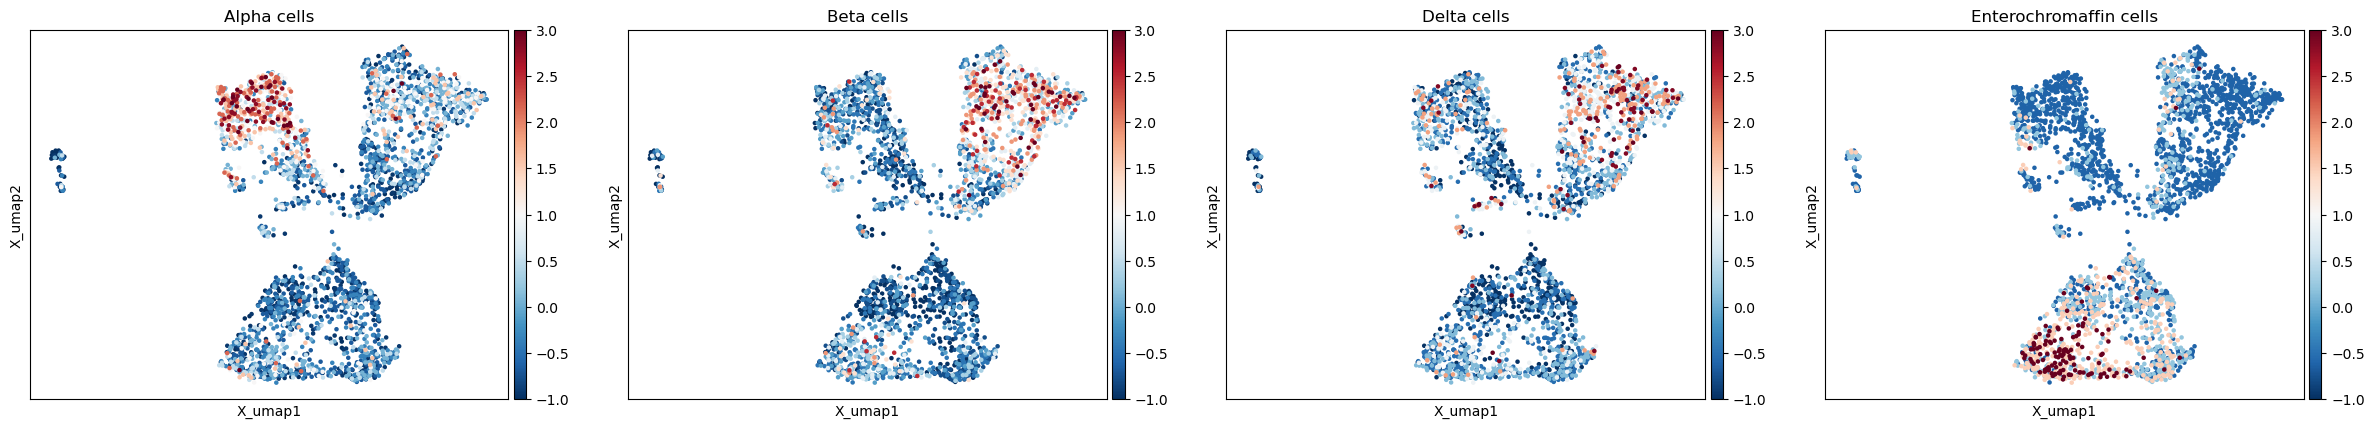

In [85]:
# Plot a few familiar cell types
with plt.rc_context():
    sc.pl.embedding(acts, basis="X_umap", color=['Alpha cells', 'Beta cells', 'Delta cells', 'Enterochromaffin cells'], cmap='RdBu_r', vmin=-1, vmax=3, show=False)
    plt.show()
    plt.close()


In [86]:
# Plot the violin plots
with plt.rc_context():
    sc.pl.violin(acts, keys=['Alpha cells', 'Beta cells', 'Delta cells', 'Enterochromaffin cells'], groupby='manual_celltype_annotation', multi_panel=True, rotation=90, show=False)
    plt.show()
    plt.close()

KeyError: "Could not find keys '['manual_celltype_annotation']' in columns of `adata.obs` or in adata.var_names."

In [ ]:
# Does just that
df = dc.rank_sources_groups(acts, groupby='manual_celltype_annotation', reference='rest', method='t-test_overestim_var')
df

group reference                   names  statistic  meanchange  \
0         SC.EC      rest  Enterochromaffin cells  32.706347    1.239900   
1         SC.EC      rest            Pinealocytes  24.064013    0.979165   
2         SC.EC      rest    Serotonergic neurons  14.627836    0.652768   
3         SC.EC      rest    Dopaminergic neurons  12.071493    0.538869   
4         SC.EC      rest             Crypt cells  11.820616    0.517399   
..          ...       ...                     ...        ...         ...   
769  progenitor      rest             Delta cells  -4.490070   -0.715827   
770  progenitor      rest        Chromaffin cells  -4.647435   -0.745649   
771  progenitor      rest               Ionocytes  -5.989543   -1.067861   
772  progenitor      rest   Enteroendocrine cells  -6.139696   -1.095018   
773  progenitor      rest                 Neurons  -6.461726   -1.006552   

             pvals      pvals_adj  
0    1.564314e-179  2.017965e-177  
1    8.665622e-111  5.589326e-109  
2     1.477921e-45   1.191574e-44  
3     2.876506e-32   1.686678e-31  
4     3.637496e-31   2.040161e-30  
..             ...            ...  
769   1.592365e-05   8.216605e-05  
770   8.328887e-06   4.671420e-05  
771   1.950844e-08   2.516589e-07  
772   9.433965e-09   1.738545e-07  
773   2.165460e-09   9.311479e-08  

[774 rows x 7 columns]

In [ ]:
# We can grab a dictionary of the top X for each group
n_ctypes = 5
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'SC.EC': ['Enterochromaffin cells',
  'Pinealocytes',
  'Serotonergic neurons',
  'Dopaminergic neurons',
  'Crypt cells'],
 'SC.alpha': ['Alpha cells',
  'Leydig cells',
  'B cells naive',
  'Clara cells',
  'Podocytes'],
 'SC.beta': ['Beta cells',
  'Choroid plexus cells',
  'Delta cells',
  'Parathyroid chief cells',
  'Retinal ganglion cells'],
 'SC.delta': ['Epsilon cells',
  'Interneurons',
  'T regulatory cells',
  'Monocytes',
  'Cardiac stem and precursor cells'],
 'SC.pre.alpha': ['Schwann cells',
  'Sebocytes',
  'Cholinergic neurons',
  'Epithelial cells',
  'Alpha cells'],
 'progenitor': ['Tanycytes',
  'Mesangial cells',
  'Adipocyte progenitor cells',
  'Bergmann glia',
  'Hematopoietic stem cells']}

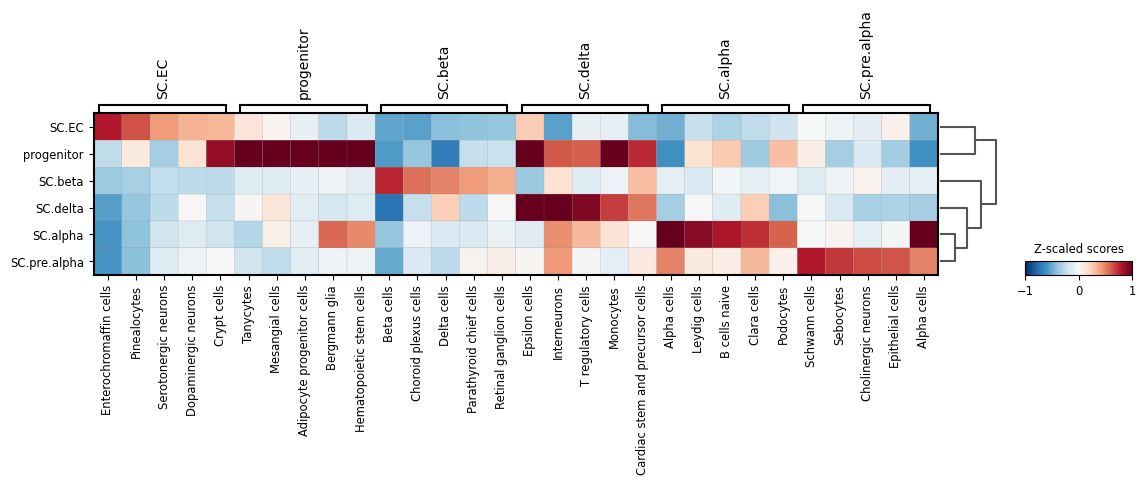

In [ ]:
# And plot that as a matrixplot
with plt.rc_context():
    sc.pl.matrixplot(
        acts, 
        ctypes_dict, 
        groupby='manual_celltype_annotation',
        dendrogram=True,
        colorbar_title='Z-scaled scores', 
        vmin=-1, 
        vmax=1, 
        cmap='RdBu_r',
        show=False
    )
    plt.show()

# DONE

---

# Scratch

"""MO1 annotation
cl_annotation = {
    "0": "SC.beta",
    "1": "SC.alpha",
    "2": "SC.EC",
    "3": "SC.EC",
    "4": "SC.beta",
    "5": "SC.EC",
    "6": "SC.beta",
    "7": "SC.pre.alpha",
    "8": "SC.beta",
    "9": "progenitor",
    "10": "SC.delta",
    "11": "SC.pre.alpha",
    "12": "SC.beta",
}
"""